In [1]:
import sys
import pathlib
sys.path.append(str(pathlib.PurePath(pathlib.Path.cwd().parent)))

import os
import multiprocessing
import time
import h5py
import numpy as np
import matplotlib.pyplot as plt
import networkx as nx
import pandas as pd

import dimod
import dwave
import dwave.system
from dwave.system import DWaveSampler, EmbeddingComposite, FixedEmbeddingComposite
import dwave.inspector
import dwave_networkx as dnx
import minorminer

from SALib.sample import sobol as salib_sample_sobol

from src.particle_funcs import distance_matrix as distance_matrix
from src.particle_funcs import io as particles_io
import src.leap_funcs.qubo.q_matrix as q_matrix

from src import leap_funcs as leap_funcs
from src.leap_funcs import embedding_quality
from src.leap_funcs.qubo import parameterstudy

from src import h5py_funcs
from src.h5py_funcs import discoveries, init_custom_getstates, io, parameterstudy_using_info_file

Custom getstate functions for dwave.cloud.config.models.ClientConfig, dwave.cloud.client.qpu.Client, dwave.cloud.solver.StructuredSolver, dwave.system.samplers.dwave_sampler.DWaveSampler, dwave.system.composites.embedding.FixedEmbeddingComposite have been initialized.


In [2]:
study_name = 'sub_2'
study_folder_path = pathlib.Path.cwd().joinpath('01_out\\'+study_name)

info_file_name = r'study_params_small.h5'
#info_file_name = r'study_params_sub3.h5'
info_file_name_path = pathlib.Path.joinpath(study_folder_path, info_file_name)
samples_folder_name = r'samples'
print(str(info_file_name_path)[-3:])
assert info_file_name_path.exists(), f'Info file does not exist. Check info_file_name_path ({info_file_name_path})'

.h5


In [3]:
#with h5py.File(pathlib.Path.joinpath(study_folder_path, info_file_name)) as info_f:
#    study_read = info_f['info']['study'][()]
#study_read

dict_info_read = h5py_funcs.io.read_info_from_hdf5_file(file_name_path=info_file_name_path, infoset_name = 'info')

In [4]:
dict_info_read.keys()

dict_keys(['attrs', 'DEMs', 'nearest_neighbours', 'qubos', 'embs_files', 'study', 'time_history'])

In [5]:
print(dict_info_read['study'])
study_read = dict_info_read['study']['data']
study_read.dtype.names
est_runts = study_read['sets']['estimated_runtime']
cum_est_runts = np.sum(est_runts)
print(est_runts)
print('cummulative estimated runtime for 1000 samples each is [h]:', cum_est_runts/3600)


{'attrs': {}, 'data': array([([(1699.68586519, 5652.84688957, 3665.31455889,  5.50463482)], b'zz_4593727025'),
       ([( 465.3469867 , 5652.84688957, 3665.31455889,  4.27029594)], b'zz_5807383795'),
       ([(1699.68586519, 5952.07219943, 3665.31455889,  5.50493404)], b'zz_1958660811'),
       ...,
       ([(1012.19818493, 3257.08045624, 2212.30357885,  3.36174039)], b'zz_5434934699'),
       ([(1012.19818493, 3451.65074803, 9009.77106765, 10.15940245)], b'zz_3031641440'),
       ([(1012.19818493, 3451.65074803, 2212.30357885,  3.36193496)], b'zz_3995870252')],
      dtype=[('sets', [('annealing_time', '<f8'), ('programming_thermalization', '<f8'), ('readout_thermalization', '<f8'), ('estimated_runtime', '<f8')], (1,)), ('identifiers', 'S13')])}
[[ 5.50463482]
 [ 4.27029594]
 [ 5.50493404]
 ...
 [ 3.36174039]
 [10.15940245]
 [ 3.36193496]]
cummulative estimated runtime for 1000 samples each is [h]: 3.492540608577411


In [6]:
del study_read, est_runts, cum_est_runts

##########
###
###
### create large in-memory-datastructure that holds all samples and timing information
###
### 1.) check which parameterset has been started/finished (just out of curiosity, is not used further)
### 2.) create pandas.df with all parametersets. Starting entries are 'started' and 'finished',
###            if parameterset was not started, the df does not hold any more information,
###            if          -''-        finished, the df does not hold samples
###
#########

In [7]:
array_identifiers = dict_info_read['study']['data']['identifiers']
print(array_identifiers.shape[0])
started_psets = []
finished_psets = []
for p_set_id in array_identifiers:
    t_hist_pset_data = dict_info_read['time_history'][p_set_id.decode('utf-8')]['data']
    yyyy_start = t_hist_pset_data[1].decode('utf-8')[:4] # year is sufficient in this case, because default date is in year 1910
    yyyy_finish = t_hist_pset_data[2].decode('utf-8')[:4] # year is sufficient in this case, because default date is in year 1910
    if yyyy_start == '2024':
        started_psets.append(p_set_id)
    if yyyy_finish == '2024':
        finished_psets.append(p_set_id)

print(started_psets)
print(finished_psets)
print('{p1}/{p2} p_sets have been started, \n {p3}/{p2} p_sets have been finished'.format(p1=len(started_psets), p2=array_identifiers.shape[0], p3=len(finished_psets)))


2048
[b'zz_4593727025', b'zz_5807383795', b'zz_1958660811', b'zz_4977448398', b'zz_9861726400', b'zz_4018132467', b'zz_8564050917', b'zz_0774385663', b'zz_2404178199', b'zz_2608120291', b'zz_2432726480', b'zz_0998746293', b'zz_0732748750', b'zz_1064692411', b'zz_7077342806', b'zz_9150463428', b'zz_1796819985', b'zz_7013897896', b'zz_1423205692', b'zz_2474862592', b'zz_2282724113', b'zz_4288610339', b'zz_0484760364', b'zz_3223161463', b'zz_8103807342', b'zz_9722018590', b'zz_0776510773', b'zz_3828246484', b'zz_5235568123', b'zz_8673245415', b'zz_0314807620', b'zz_1930124932', b'zz_4801656389', b'zz_6729846563', b'zz_2140734774', b'zz_5331655260', b'zz_7102613420', b'zz_3778019146', b'zz_0121970642', b'zz_1910331181', b'zz_9846935178', b'zz_0023526387', b'zz_0911420757', b'zz_1803606211', b'zz_0884514502', b'zz_5769960721', b'zz_5792089191', b'zz_0907318371', b'zz_1003279652', b'zz_7788638695', b'zz_7814898618', b'zz_4415153621', b'zz_9943921963', b'zz_7685401782', b'zz_1923096856', b'zz

In [8]:
list_files_in_samples_dir = os.listdir(pathlib.Path.joinpath(study_folder_path, samples_folder_name))
dict_for_df = {}
_it = 0
#for p_set_id in array_identifiers:
#    _it += 1
#    print(f'{_it}/{array_identifiers.shape[0]}', end='\r')
#    p_set_id_dec = p_set_id.decode('utf-8')
#    p_set_file_name_path = pathlib.Path.joinpath(study_folder_path, samples_folder_name, p_set_id_dec+'.h5')
#    dict_for_df.update({p_set_id_dec: h5py_funcs.io.read_info_from_hdf5_file(file_name_path=p_set_file_name_path, infoset_name = 'custom')})
#dict_for_df
def read_answs_to_dict(p_set_id):
    global _it
    global dict_for_df
    _it += 1
    p_set_id_dec = p_set_id.decode('utf-8')
    set_in_dir = p_set_id_dec+'.h5' in list_files_in_samples_dir
    print(f'{_it}/{array_identifiers.shape[0]} file {p_set_id_dec+'.h5'} in dir: {set_in_dir}\r', end='')
    if set_in_dir:
        p_set_file_name_path = pathlib.Path.joinpath(study_folder_path, samples_folder_name, p_set_id_dec+'.h5')
        dict_for_df.update({p_set_id_dec: h5py_funcs.io.read_info_from_hdf5_file(file_name_path=p_set_file_name_path, driver='core')})
    return



In [9]:
#for p_set_id in array_identifiers[:10]:
#    read_answs_to_dict(p_set_id=p_set_id)


In [10]:
# apparently reading hdf5 files is not io bound in this case, so 1 thread does as well as more
#for num_threads in (50,25,15,10,5):
#for num_threads in (1,2,3,4,5):
for num_threads in (2,):
    dict_for_df = {}
    tic = time.time()
    from multiprocessing import pool
    tp = multiprocessing.pool.ThreadPool(num_threads)
    tp.map(read_answs_to_dict, array_identifiers[:])
    toc = time.time()
    print(f'\n{num_threads} took [s] {toc-tic}')
#        #160/2048 file zz_7106551505.h5 in dir: True
#        #1 took [s] 75.3208556175232
#        #310/2048 file zz_7106551505.h5 in dir: True
#        #2 took [s] 66.5232310295105
#        #460/2048 file zz_1523292874.h5 in dir: True
#        #3 took [s] 68.72280383110046
#        #610/2048 file zz_7106551505.h5 in dir: True
#        #4 took [s] 70.92504715919495
#        #760/2048 file zz_7106551505.h5 in dir: True
#        #5 took [s] 76.96953821182251
#dict_for_df

2048/2048 file zz_2281994804.h5 in dir: Truee
2 took [s] 209.7301697731018


In [100]:
print(dict_for_df.__sizeof__()) # size in memory in bytes
print(len(dict_for_df)) # number of keys in dict

13040
464


In [101]:
first_key = [key for key in dict_for_df.keys()][0]
dict_for_df[first_key]

{'custom': {'composite': {'children': {'child_0': {'_adjacency': {'100': {'attrs': {},
       'data': array([  99,  101, 4965, 4935, 4905, 4875,  115, 4950, 4920, 4890, 4860])},
      '1000': {'attrs': {},
       'data': array([4865, 4834,  999, 4999, 1001, 4970, 4940, 4910, 4880, 4849, 1015,
              4984, 4955, 4925, 4895])},
      '1001': {'attrs': {},
       'data': array([5120, 5090, 5060, 5029, 1000, 1002, 5164, 5135, 5105, 5075, 5045,
              5014, 1016, 5179, 5150])},
      '1002': {'attrs': {},
       'data': array([5344, 5315, 5285, 5255, 1001, 5194, 1003, 5225, 5359, 5330, 5300,
              5270, 5240, 5209, 1017])},
      '1003': {'attrs': {},
       'data': array([5539, 5510, 5480, 1002, 5450, 1004, 5389, 5420, 5524, 5495, 5465,
              1018, 5435, 5405, 5374])},
      '1004': {'attrs': {},
       'data': array([5600, 5569, 5704, 1003, 5675, 5645, 5615, 5585, 5554, 5719, 5690,
              1019, 5660, 5630])},
      '1005': {'attrs': {},
       'data': 

In [102]:
#import json
#dict_for_df[first_key]['custom']['composite']['target_structure']
#def jsonify(inp):
#    if isinstance(inp, np.ndarray):
#        jsonified = inp.tolist()
#    elif isinstance(inp, bytes):
#        jsonified = inp.decode('utf-8')
#    elif isinstance(inp, np.int32):
#        jsonified = int(inp)
#    elif isinstance(inp,np.float64):
#        jsonified = float(inp)
#    elif isinstance(inp, np.bool_):
#        jsonified = bool(inp)
#    else:
#        print(inp, type(inp))
#        raise ValueError(f'Object of type {inp.__class__.__name__} is not JSON serializable')
#    return jsonified
#
#def recurse(d, print_prefix=' '):
#    if isinstance(d,np.ndarray):
#        print(print_prefix + 'found np.ndarray')
#        print(d.tolist())
#    elif isinstance(d, np.float64 | np.int32 | np.bool_):
#        print(print_prefix + 'found np.float/int/bool_')
#    elif isinstance(d, bytes):
#        print(print_prefix + 'found bytes')
#        print(print_prefix, d)
#        print(print_prefix, d.decode('utf-8'))
#    else:
#        for key in d.keys():
#            print(print_prefix + key)
#            recurse(d[key], print_prefix=print_prefix+' ')
#
#with open(pathlib.Path.joinpath(study_folder_path, 'results.json'), 'wt') as f:
#    #json.dump(dict_for_df, f, default=jsonify, indent=1) # indent for newlines and one whitespace per level
#    for id in list(dict_for_df.keys())[:3]:
#        print(id)
#        #json.dump({id: dict_for_df[id]}, f, default=jsonify, indent=1) # indent for newlines and one whitespace per level
        

In [103]:
#pd.DataFrame.from_dict(dict_for_df) # doesnt seem too helpful

In [104]:
import ast
import dwave.samplers

num_particles = 5
qubo = dict_info_read['qubos'][f'{num_particles}_{num_particles}']

#sim_annealing_sample = dimod.samplers.ExactSolver().sample_qubo(
#    {ast.literal_eval(key): value['data'] for key, value in qubo.items()})
sim_annealing_sample = dwave.samplers.SimulatedAnnealingSampler().sample_qubo(
    {ast.literal_eval(key): value['data'] for key, value in qubo.items()},
    num_reads=1000)
sim_annealing_sample = sim_annealing_sample.aggregate() # accumulates number of occurences

In [105]:
type(sim_annealing_sample)

dimod.sampleset.SampleSet

In [106]:
a = sim_annealing_sample
b = sim_annealing_sample.first
c = a.samples(n=5, sorted_by='energy')
d = a.record
print(c[0])
print(b)
#for i in range(np.shape(sim_annealing_sample._record)[0]): for exact solver all possible solutions are stored
#    print(sim_annealing_sample._record[i])



{(1, 1): 0, (1, 2): 0, (1, 3): 1, (1, 4): 0, (1, 5): 0, (2, 1): 1, (2, 2): 0, (2, 3): 0, (2, 4): 0, (2, 5): 0, (3, 1): 0, (3, 2): 0, (3, 3): 0, (3, 4): 1, (3, 5): 0, (4, 1): 0, (4, 2): 0, (4, 3): 0, (4, 4): 0, (4, 5): 1, (5, 1): 0, (5, 2): 1, (5, 3): 0, (5, 4): 0, (5, 5): 0}
Sample(sample={(1, 1): 0, (1, 2): 0, (1, 3): 1, (1, 4): 0, (1, 5): 0, (2, 1): 1, (2, 2): 0, (2, 3): 0, (2, 4): 0, (2, 5): 0, (3, 1): 0, (3, 2): 0, (3, 3): 0, (3, 4): 1, (3, 5): 0, (4, 1): 0, (4, 2): 0, (4, 3): 0, (4, 4): 0, (4, 5): 1, (5, 1): 0, (5, 2): 1, (5, 3): 0, (5, 4): 0, (5, 5): 0}, energy=-9.902053032706831, num_occurrences=10)


In [107]:
sum_i = 1
sum_j = 1
for i in range(num_particles):
    print(i, sum_i)
    if sum_i != 1:
        raise ValueError('particle i was not assigned exactly one time')
    sum_i = 0
    for j in range(num_particles):
        val = b.sample[(i+1,j+1)]
        #print(val)
        sum_i += val

for j in range(num_particles):
    print(j, sum_j)
    if sum_j != 1:
        raise ValueError('position j was not assigned to exactly one time')
    sum_j = 0
    for i in range(num_particles):
        val = b.sample[(i+1,j+1)]
        #print(val)
        sum_j += val

0 1
1 1
2 1
3 1
4 1
0 1
1 1
2 1
3 1
4 1


In [108]:
d.sort(order = 'energy')

In [109]:
d[:10].sample

array([[0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 1,
        0, 0, 0],
       [0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1,
        0, 0, 0],
       [0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1,
        0, 0, 0],
       [0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0,
        1, 0, 0],
       [1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 1,
        0, 0, 0],
       [1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0,
        1, 0, 0],
       [0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1,
        0, 0, 0],
       [0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 1, 0,
        0, 0, 0],
       [1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1,
        0, 0, 0],
       [1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0,
        1, 0, 0]], dtype=int8)

In [110]:
def group_subs_per_run(samplesets_names:list[str]):
    names_split = [_tmp.split('_') for _tmp in samplesets_names]
    #assert all([len(n)==2 for n in names_split]), 'names_split must be list of lists, where each inner list is of len 2 exactly, because submissions are named by run_submission'
    names_runs_unique = [key for key in dict.fromkeys(s[0] for s in names_split).keys()] # contains same elements as "set(s[0] for s in names_split)", but additionally preserves order
    #print(names_runs_unique)
    names_runs_unique_iter = iter(names_runs_unique)
    names_subs_per_run = []
    _tmp_str = next(names_runs_unique_iter)
    _tmp_list = []
    for name_split in names_split:
        #print(name_split)
        #print(_tmp_str)
        if name_split[0] != _tmp_str:
            names_subs_per_run.append(_tmp_list)
            _tmp_list = [name_split[1:]]
            _tmp_str = next(names_runs_unique_iter)    
        else:
            _tmp_list.append(name_split[1:])
    names_subs_per_run.append(_tmp_list)
    return names_runs_unique, names_subs_per_run

def evaluate_success_rate(exact_sols:dimod.sampleset.SampleSet=None, sample_sols:dimod.sampleset.SampleSet=None, n_exact:int=1, n_samples:int=1, is_print_sols:bool=False, is_print_meta:bool=False, print_prefix:str=' '):
    samplesets_names = list(sample_sols.keys())
    names_runs, names_subs_per_run = group_subs_per_run(samplesets_names=samplesets_names)
    num_runs = len(names_runs)
    num_subs_per_run = [len(n) for n in names_subs_per_run]
    num_samples = 0
    num_samples_per_run = []
    num_samples_per_sub_per_run = []
    num_runs_is_found_best = 0
    num_samples_is_found_best = 0
    num_samples_is_found_best_per_run = []
    is_found_best_per_run = []
    num_matched = 0
    num_matched_per_run = []
    num_matched_per_sub_per_run = []
    num_samples_matched = 0
    num_samples_matched_per_run = []
    num_samples_matched_per_sub_per_run = []
    
    if is_print_meta:
        print(print_prefix, 'Sampleset keys:', samplesets_names)
        print(print_prefix, 'Names runs:', names_runs)
        print(print_prefix, 'Names subs per run:', names_subs_per_run)
        print(print_prefix, 'Number of runs:', num_runs)
        print(print_prefix, 'Number of submissions per run:', num_subs_per_run)

    return_dict = {}
    return_dict['num_runs_is_found_best'] = num_runs_is_found_best
    return_dict['num_samples_is_found_best'] = num_samples_is_found_best
    return_dict['num_samples_is_found_best_per_run'] = num_samples_is_found_best_per_run
    return_dict['is_found_best_per_run'] = is_found_best_per_run
    return_dict['num_samples'] = 0
    return_dict['num_runs'] = num_runs
    return_dict['num_subs_per_run'] = num_subs_per_run
    return_dict['num_samples'] = num_samples
    return_dict['num_samples_per_run'] = num_samples_per_run
    return_dict['num_samples_per_sub_per_run'] = num_samples_per_sub_per_run
    return_dict['num_matched'] = num_matched
    return_dict['num_matched_per_run'] = num_matched_per_run
    return_dict['num_matched_per_sub_per_run'] = num_matched_per_sub_per_run
    return_dict['num_samples_matched'] = num_samples_matched
    return_dict['num_samples_matched_per_run'] = num_samples_matched_per_run
    return_dict['num_samples_matched_per_sub_per_run'] = num_samples_matched_per_sub_per_run
    return_dict['submissions'] = {}
    for _i, name_run in enumerate(names_runs):
        num_samples_per_run.append(0)
        num_samples_per_sub_per_run.append([])
        is_found_best_per_run.append(False)
        num_matched_per_run.append(0)
        num_matched_per_sub_per_run.append([])
        num_samples_matched_per_run.append(0)
        num_samples_matched_per_sub_per_run.append([])
        num_samples_is_found_best_per_run.append(0)
        for name_sub in names_subs_per_run[_i]:
            if isinstance(name_sub, list):
                name = name_run
                for n in name_sub:
                    name += '_' + n
            elif isinstance(name_sub, str):
                name = name_run + '_' + name_sub
            else:
                raise ValueError(f'Could not create key of sampleset from name_sub={name_sub}')
            
            samples = sample_sols[name]['_record']['data']
            samples.sort(order='energy')
            if is_print_sols:
                print(print_prefix, 'Sampled solutions')
                print(samples[:n_samples])
                print(print_prefix, 'Exact solutions')
                print(exact_sols[:n_exact])
        
            #num_samples += samples.shape[0]
            _num_samples_sub = np.sum(samples['num_occurrences'])
            num_samples +=  _num_samples_sub
            num_samples_per_run[-1] += _num_samples_sub
            num_samples_per_sub_per_run[-1].append(_num_samples_sub)
            return_dict['num_samples'] = num_samples
            return_dict['num_samples_per_run'] = num_samples_per_run
            return_dict['num_samples_per_sub_per_run'] = num_samples_per_sub_per_run
            return_dict['submissions'][name] = {}
            return_dict['submissions'][name]['num_samples'] = _num_samples_sub
            return_dict['submissions'][name]['is_found_best'] = np.array_equal(samples['sample'][0], exact_sols['sample'][0])
            is_found_best_per_run[-1] = is_found_best_per_run[-1] or return_dict['submissions'][name]['is_found_best']
            if return_dict['submissions'][name]['is_found_best']:
                num_samples_is_found_best += samples['num_occurrences'][0]
                num_samples_is_found_best_per_run[-1] += (samples['num_occurrences'][0])
            return_dict['submissions'][name]['num_matched'] = 0
            return_dict['submissions'][name]['matches_sample_exact'] = []
            num_matched_per_sub_per_run[-1].append(0)
            num_samples_matched_per_sub_per_run[-1].append(0)
            for i_s in range(n_samples):
                for i_e in range(n_exact):
                    is_contained = np.array_equal(samples['sample'][i_s], exact_sols['sample'][i_e])
                    if is_print_meta:
                        print('matched samp exac:', i_s, i_e, is_contained)
                    if is_contained:
                        num_matched += 1
                        num_matched_per_run[-1] += 1
                        num_matched_per_sub_per_run[-1][-1] += 1
                        num_samples_matched += samples['num_occurrences'][i_s]
                        num_samples_matched_per_run[-1] += samples['num_occurrences'][i_s]
                        num_samples_matched_per_sub_per_run[-1][-1] += samples['num_occurrences'][i_s]
                        
                        return_dict['submissions'][name]['matches_sample_exact'].append((i_s, i_e))
            return_dict['submissions'][name]['num_matched'] = num_matched_per_sub_per_run[-1][-1].real
            return_dict['num_matched'] = num_matched
            return_dict['num_matched_per_run'] = num_matched_per_run
            return_dict['num_matched_per_sub_per_run'] = num_matched_per_sub_per_run
            return_dict['num_samples_matched'] = num_samples_matched
            return_dict['num_samples_matched_per_run'] = num_samples_matched_per_run
            return_dict['num_samples_matched_per_sub_per_run'] = num_samples_matched_per_sub_per_run
    num_runs_is_found_best = np.sum(is_found_best_per_run)
    return_dict['num_runs_is_found_best'] = num_runs_is_found_best
    return_dict['num_samples_is_found_best'] = num_samples_is_found_best
    return_dict['num_samples_is_found_best_per_run'] = num_samples_is_found_best_per_run
            
    
    return return_dict

n_samples_to_compare = 5
n_correct_sols_to_compare = 5
success_dict = {}
for id in list(dict_for_df.keys())[:]:
    #print(id)
    samplesets = dict_for_df[id]['custom']['sampleset']
    eval_dict = evaluate_success_rate(exact_sols=d, sample_sols=samplesets, n_exact=n_correct_sols_to_compare, n_samples=n_samples_to_compare, is_print_sols=False, is_print_meta=False)
    print(eval_dict)
    success_dict[id] = {'is_found_best': np.any([val['is_found_best'] for val in eval_dict['submissions'].values()]), **eval_dict}

for key in success_dict.keys():
    print(key, success_dict[key])

{'num_runs_is_found_best': 9, 'num_samples_is_found_best': 32, 'num_samples_is_found_best_per_run': [2, 0, 1, 4, 3, 6, 5, 4, 3, 4], 'is_found_best_per_run': [True, False, True, True, True, True, True, True, True, True], 'num_samples': 2900, 'num_runs': 10, 'num_subs_per_run': [2, 2, 2, 2, 2, 2, 2, 2, 2, 2], 'num_samples_per_run': [290, 290, 290, 290, 290, 290, 290, 290, 290, 290], 'num_samples_per_sub_per_run': [[142, 148], [142, 148], [142, 148], [142, 148], [142, 148], [142, 148], [142, 148], [142, 148], [142, 148], [142, 148]], 'num_matched': 72, 'num_matched_per_run': [9, 5, 7, 5, 9, 8, 8, 9, 5, 7], 'num_matched_per_sub_per_run': [[4, 5], [3, 2], [4, 3], [2, 3], [4, 5], [5, 3], [4, 4], [5, 4], [4, 1], [3, 4]], 'num_samples_matched': 163, 'num_samples_matched_per_run': [28, 10, 14, 13, 12, 19, 21, 17, 11, 18], 'num_samples_matched_per_sub_per_run': [[9, 19], [4, 6], [8, 6], [6, 7], [4, 8], [11, 8], [10, 11], [8, 9], [10, 1], [7, 11]], 'submissions': {'000_0142': {'num_samples': 142,

In [111]:
num_submits = 0
for key, value in success_dict.items():
    for spr in value['num_subs_per_run']:
        num_submits += spr
print(num_submits)

7470


In [112]:
def x_ticks_grouped(bar_values, gsize, group_dist=0.3):
    #group_dist = 0.3  # the distance between groups
    multiplier = 0
    rects = []
    for chunk in np.array_split(np.array(bar_values),gsize):
        #x = np.linspace(0,1-group_dist,len(chunk), endpoint=False)
        #offset = 1 * multiplier
        group_dist = 3
        x = np.linspace(0,len(bar_values)/gsize-group_dist,len(chunk), endpoint=False)
        offset = gsize * multiplier
        rects.extend(x + offset)
        multiplier += 1
    print(bar_values)
    print(rects)
    return rects

In [113]:
import matplotlib.cm as cm
import matplotlib.axes as am
import matplotlib.pyplot as plt
%matplotlib widget

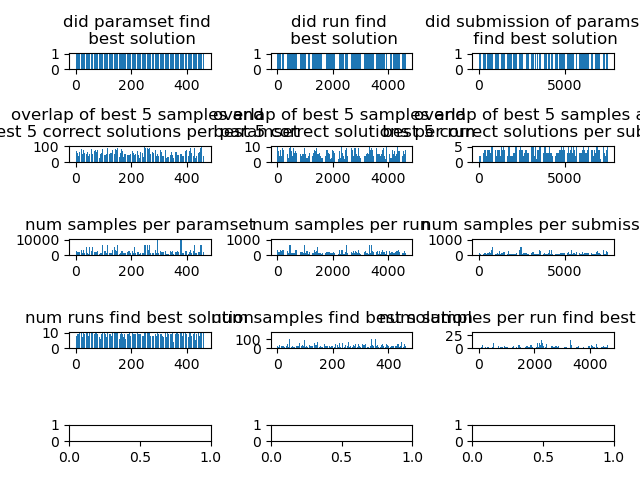

In [114]:
x_axis_labels = [key for key in success_dict.keys()]
bar_values_param_found_best = [val['is_found_best'] for val in success_dict.values()]
bar_values_run_found_best = [val2 for val in success_dict.values() for val2 in val['is_found_best_per_run']]
bar_values_submission_found_best = [val2['is_found_best'] for val in success_dict.values() for val2 in val['submissions'].values()]
bar_values_param_num_matched = [val['num_matched'] for val in success_dict.values()]
bar_values_run_num_matched = [val2 for val in success_dict.values() for val2 in val['num_matched_per_run']]
bar_values_submission_num_matched = [val3 for val in success_dict.values() for val2 in val['num_matched_per_sub_per_run'] for val3 in val2]
bar_values_param_samples = [val['num_samples'] for val in success_dict.values()]
bar_values_run_samples = [val2 for val in success_dict.values() for val2 in val['num_samples_per_run']]
bar_values_submission_samples= [val3 for val in success_dict.values() for val2 in val['num_samples_per_sub_per_run'] for val3 in val2]
bar_values_num_runs_found_best = [val['num_runs_is_found_best'] for val in success_dict.values()]
bar_values_num_samples_found_best = [val['num_samples_is_found_best'] for val in success_dict.values()]
bar_values_num_samples_found_best_per_run = [val2 for val in success_dict.values() for val2 in val['num_samples_is_found_best_per_run']]
figs, axs = plt.subplots(nrows=5, ncols=3)
axs[0,0].set_title('did paramset find \n best solution')
axs[0,0].bar(range(len(bar_values_param_found_best)), bar_values_param_found_best)
axs[0,1].set_title('did run find \n best solution')
axs[0,1].bar(range(len(bar_values_run_found_best)), bar_values_run_found_best)
#axs[0,1].bar(x_ticks_grouped(bar_values_run_found_best, len(success_dict)), bar_values_run_found_best, width=10/(len(bar_values_run_found_best)))
#axs[0,0].set_xticks(axs[0,0].get_xticks())
#_ = axs[0,0].set_xticklabels(axs[0,0].get_xticklabels(), rotation=45)
axs[0,2].set_title('did submission of paramset \n find best solution')
axs[0,2].bar(range(len(bar_values_submission_found_best)), bar_values_submission_found_best)
axs[1,0].set_title('overlap of best {n_s} samples and \n best {n_e} correct solutions per paramset'.format(n_s=n_samples_to_compare, n_e=n_correct_sols_to_compare))
axs[1,0].bar(range(len(bar_values_param_num_matched)), bar_values_param_num_matched)
axs[1,1].set_title('overlap of best {n_s} samples and \n best {n_e} correct solutions per run'.format(n_s=n_samples_to_compare, n_e=n_correct_sols_to_compare))
axs[1,1].bar(range(len(bar_values_run_num_matched)), bar_values_run_num_matched)
axs[1,2].set_title('overlap of best {n_s} samples and \n best {n_e} correct solutions per submission'.format(n_s=n_samples_to_compare, n_e=n_correct_sols_to_compare))
axs[1,2].bar(range(len(bar_values_submission_num_matched)), bar_values_submission_num_matched)
axs[2,0].set_title('num samples per paramset')
axs[2,0].bar(range(len(bar_values_param_samples)), bar_values_param_samples)
axs[2,1].set_title('num samples per run')
axs[2,1].bar(range(len(bar_values_run_samples)), bar_values_run_samples)
axs[2,2].set_title('num samples per submission')
axs[2,2].bar(range(len(bar_values_submission_samples)), bar_values_submission_samples)
axs[3,0].set_title('num runs find best solution')
axs[3,0].bar(range(len(bar_values_num_runs_found_best)), bar_values_num_runs_found_best)
axs[3,1].set_title('num samples find best solution')
axs[3,1].bar(range(len(bar_values_num_samples_found_best)), bar_values_num_samples_found_best)
axs[3,2].set_title('num samples per run find best solution')
axs[3,2].bar(range(len(bar_values_num_samples_found_best_per_run)), bar_values_num_samples_found_best_per_run)

figs.tight_layout()

In [115]:
for key, value in dict_info_read.items():
    print(key, value)

attrs {'Description': 'This file contains the information for the parameter study of the nearest neighbours', 'names': array(['annealing_time', 'programming_thermalization',
       'readout_thermalization', 'estimated_runtime'], dtype=object), 'bounds': array([[5.e-01, 2.e+03],
       [0.e+00, 1.e+04],
       [0.e+00, 1.e+04]]), 'num_vars': 3}
DEMs {'num_particles': {'01': {'attrs': {}, 'data': 5}}, 'rocky_files': {'01': {'attrs': {}, 'data': b'C:\\zz_tmp_OAH\\perf_sphere\\qdem_sub_1\\01_Particles_0005_CPU_4_GPU_0.rocky'}}}
nearest_neighbours {'01': {'attrs': {}, 'data': array([5])}}
qubos {'5_5': {'((1, 1), (1, 1))': {'attrs': {}, 'data': -1.9733201347126184}, '((1, 1), (1, 2))': {'attrs': {}, 'data': 4.0}, '((1, 1), (1, 3))': {'attrs': {}, 'data': 4.0}, '((1, 1), (1, 4))': {'attrs': {}, 'data': 4.0}, '((1, 1), (1, 5))': {'attrs': {}, 'data': 4.0}, '((1, 1), (2, 1))': {'attrs': {}, 'data': 4.0}, '((1, 1), (3, 1))': {'attrs': {}, 'data': 4.0}, '((1, 1), (4, 1))': {'attrs': {}, 'data': 

In [116]:
dict_info_read['study']['data']

array([([(1699.68586519, 5652.84688957, 3665.31455889,  5.50463482)], b'zz_4593727025'),
       ([( 465.3469867 , 5652.84688957, 3665.31455889,  4.27029594)], b'zz_5807383795'),
       ([(1699.68586519, 5952.07219943, 3665.31455889,  5.50493404)], b'zz_1958660811'),
       ...,
       ([(1012.19818493, 3257.08045624, 2212.30357885,  3.36174039)], b'zz_5434934699'),
       ([(1012.19818493, 3451.65074803, 9009.77106765, 10.15940245)], b'zz_3031641440'),
       ([(1012.19818493, 3451.65074803, 2212.30357885,  3.36193496)], b'zz_3995870252')],
      dtype=[('sets', [('annealing_time', '<f8'), ('programming_thermalization', '<f8'), ('readout_thermalization', '<f8'), ('estimated_runtime', '<f8')], (1,)), ('identifiers', 'S13')])

In [117]:
print(dict_info_read['study']['data'].dtype)
print(dict_info_read['study']['data'].dtype.names)
print(dict_info_read['study']['data']['sets'].dtype.names)
print(dict_info_read['study']['data']['identifiers'])
print()
print(dict_info_read['study']['data']['sets'])

[('sets', [('annealing_time', '<f8'), ('programming_thermalization', '<f8'), ('readout_thermalization', '<f8'), ('estimated_runtime', '<f8')], (1,)), ('identifiers', 'S13')]
('sets', 'identifiers')
('annealing_time', 'programming_thermalization', 'readout_thermalization', 'estimated_runtime')
[b'zz_4593727025' b'zz_5807383795' b'zz_1958660811' ... b'zz_5434934699'
 b'zz_3031641440' b'zz_3995870252']

[[(1699.68586519, 5652.84688957, 3665.31455889,  5.50463482)]
 [( 465.3469867 , 5652.84688957, 3665.31455889,  4.27029594)]
 [(1699.68586519, 5952.07219943, 3665.31455889,  5.50493404)]
 ...
 [(1012.19818493, 3257.08045624, 2212.30357885,  3.36174039)]
 [(1012.19818493, 3451.65074803, 9009.77106765, 10.15940245)]
 [(1012.19818493, 3451.65074803, 2212.30357885,  3.36193496)]]


In [118]:
a = np.zeros((dict_info_read['study']['data'].shape[0],))
print(a)
print(dict_info_read['study']['data']['sets'].shape)
print(dict_info_read['study']['data']['sets'].dtype.isalignedstruct)
b = np.lib.recfunctions.rec_append_fields(dict_info_read['study']['data'], 'param 1', a)
print(b)

[0. 0. 0. ... 0. 0. 0.]
(2048, 1)
False
[([(1699.68586519, 5652.84688957, 3665.31455889,  5.50463482)], b'zz_4593727025', 0.)
 ([( 465.3469867 , 5652.84688957, 3665.31455889,  4.27029594)], b'zz_5807383795', 0.)
 ([(1699.68586519, 5952.07219943, 3665.31455889,  5.50493404)], b'zz_1958660811', 0.)
 ...
 ([(1012.19818493, 3257.08045624, 2212.30357885,  3.36174039)], b'zz_5434934699', 0.)
 ([(1012.19818493, 3451.65074803, 9009.77106765, 10.15940245)], b'zz_3031641440', 0.)
 ([(1012.19818493, 3451.65074803, 2212.30357885,  3.36193496)], b'zz_3995870252', 0.)]


In [119]:
print(b.dtype)

(numpy.record, [('sets', [('annealing_time', '<f8'), ('programming_thermalization', '<f8'), ('readout_thermalization', '<f8'), ('estimated_runtime', '<f8')], (1,)), ('identifiers', 'S13'), ('param 1', '<f8')])


In [120]:
dict_info_read['study']['data']['sets'].copy().view(dtype=np.float64, type=np.ndarray)

array([[1.69968587e+03, 5.65284689e+03, 3.66531456e+03, 5.50463482e+00],
       [4.65346987e+02, 5.65284689e+03, 3.66531456e+03, 4.27029594e+00],
       [1.69968587e+03, 5.95207220e+03, 3.66531456e+03, 5.50493404e+00],
       ...,
       [1.01219818e+03, 3.25708046e+03, 2.21230358e+03, 3.36174039e+00],
       [1.01219818e+03, 3.45165075e+03, 9.00977107e+03, 1.01594024e+01],
       [1.01219818e+03, 3.45165075e+03, 2.21230358e+03, 3.36193496e+00]])

In [121]:
started_sets = [s.encode('utf-8') for s in success_dict.keys()]
ids_study = np.zeros(len(started_sets),dtype=int)
for i, id_started in enumerate(started_sets):
    ids_study[i] = np.argwhere(id_started == dict_info_read['study']['data']['identifiers'])[0,0]
study_matched_started_ids = np.lib.recfunctions.rec_append_fields(dict_info_read['study']['data'][ids_study], 'started sets', started_sets)
print(len(started_sets))
print(started_sets)
print(ids_study)
print(study_matched_started_ids)
print(study_matched_started_ids['sets'].dtype)
print(study_matched_started_ids['sets'].view((np.float64, len(study_matched_started_ids['sets'].dtype.names))).copy().shape)

464
[b'zz_4593727025', b'zz_5807383795', b'zz_2529181774', b'zz_1958660811', b'zz_1284240285', b'zz_4977448398', b'zz_1345385484', b'zz_9861726400', b'zz_7930909369', b'zz_4018132467', b'zz_2468693100', b'zz_8564050917', b'zz_5341415076', b'zz_7129485511', b'zz_0774385663', b'zz_9360591683', b'zz_2404178199', b'zz_4042360076', b'zz_2608120291', b'zz_3796765783', b'zz_2432726480', b'zz_5138442267', b'zz_0998746293', b'zz_8484679801', b'zz_0732748750', b'zz_5884195139', b'zz_2235555733', b'zz_1064692411', b'zz_5227913966', b'zz_7077342806', b'zz_7999721110', b'zz_9150463428', b'zz_8009674746', b'zz_1796819985', b'zz_6969501196', b'zz_7013897896', b'zz_7270038988', b'zz_1423205692', b'zz_1221709778', b'zz_2474862592', b'zz_1545581473', b'zz_8414321564', b'zz_2282724113', b'zz_8179067470', b'zz_4288610339', b'zz_0484760364', b'zz_6021302732', b'zz_3223161463', b'zz_6419553955', b'zz_8103807342', b'zz_8636209131', b'zz_9722018590', b'zz_5618333541', b'zz_0776510773', b'zz_4089864959', b'zz_

In [122]:
results_names = list(list(success_dict.values())[0].keys())
to_remove = ['is_found_best_per_run', 'num_subs_per_run', 'num_samples_per_run', 'num_samples_per_sub_per_run', 'num_matched_per_run'\
             , 'num_matched_per_sub_per_run', 'num_samples_matched_per_run', 'num_samples_matched_per_sub_per_run', 'submissions', 'num_samples_is_found_best_per_run']
for s in to_remove:
    results_names.remove(s)

name_fraction_matched = f'fraction_samples_matched_{n_samples_to_compare}_samps_{n_correct_sols_to_compare}_sols'
results_names.append('fraction_samples_is_found_best')
results_names.append(name_fraction_matched)
print(results_names)

sampler_array = np.zeros((len(started_sets),len(results_names)))
for key, value in success_dict.items():
    id_row = np.argwhere(key.encode('utf-8') == study_matched_started_ids['identifiers'])[0,0]
    for key2, value2 in value.items():
        if key2 in results_names:
            id_col = np.argwhere(key2 == np.array(results_names))
            sampler_array[id_row,id_col] = value2
id_tmp_val = np.argwhere('fraction_samples_is_found_best' == np.array(results_names))[0,0]
id_tmp_num = np.argwhere('num_samples_is_found_best' == np.array(results_names))[0,0]
id_tmp_den = np.argwhere('num_samples' == np.array(results_names))[0,0]
sampler_array[:,id_tmp_val] = sampler_array[:,id_tmp_num] / sampler_array[:,id_tmp_den]
id_tmp_val = np.argwhere(name_fraction_matched == np.array(results_names))[0,0]
id_tmp_num = np.argwhere('num_samples_matched' == np.array(results_names))[0,0]
sampler_array[:,id_tmp_val] = sampler_array[:,id_tmp_num] / sampler_array[:,id_tmp_den]
print(np.max(sampler_array[:,-1]))
print(sampler_array.shape)

['is_found_best', 'num_runs_is_found_best', 'num_samples_is_found_best', 'num_samples', 'num_runs', 'num_matched', 'num_samples_matched', 'fraction_samples_is_found_best', 'fraction_samples_matched_5_samps_5_sols']
0.097
(464, 9)


In [123]:
np.savetxt('01_out/sampler_array.txt', sampler_array)

In [124]:
import torch
import gpytorch

In [125]:
class MultitaskGPModel(gpytorch.models.ExactGP):
                def __init__(self, train_x, train_y, likelihood):
                    super(MultitaskGPModel, self).__init__(train_x, train_y, likelihood)
                    self.mean_module = gpytorch.means.MultitaskMean(
                        gpytorch.means.ConstantMean(), num_tasks=sampler_array.shape[1]
                    )
                    self.covar_module = gpytorch.kernels.MultitaskKernel(
                        gpytorch.kernels.RBFKernel(), num_tasks=sampler_array.shape[1]
                    )

                def forward(self, x):
                    mean_x = self.mean_module(x)
                    covar_x = self.covar_module(x)
                    return gpytorch.distributions.MultitaskMultivariateNormal(mean_x, covar_x)

            # Instantiate multi-task likelihood and GP model 
train_x = torch.tensor(study_matched_started_ids['sets'].view(np.float64).copy()).to(torch.float)
test_x = torch.tensor(dict_info_read['study']['data']['sets'].view(np.float64).copy()).to(torch.float)
#_tmp_train_dtype = study_matched_started_ids['sets'].dtype
#_tmp_test_dtype = dict_info_read['study']['data']['sets'].dtype
#_tmp_train_data = study_matched_started_ids['sets'].view((np.float64, len(_tmp_train_dtype.names))).copy()
#_tmp_test_data = dict_info_read['study']['data']['sets'].view((np.float64, len(_tmp_test_dtype.names))).copy()
#train_x = torch.tensor(_tmp_train_data).to(torch.float)
#test_x = torch.tensor(_tmp_test_data).to(torch.float)
#del(_tmp_train_dtype, _tmp_test_dtype, _tmp_train_data, _tmp_test_data)

train_y = torch.tensor(sampler_array).to(torch.float)

likelihood = gpytorch.likelihoods.MultitaskGaussianLikelihood(num_tasks=sampler_array.shape[1])
model = MultitaskGPModel(train_x, train_y, likelihood)

In [126]:
# Switch to training mode
model.train()
likelihood.train()

# Define optimizer and loss function
optimizer = torch.optim.Adam(model.parameters(), lr=0.1)
mll = gpytorch.mlls.ExactMarginalLogLikelihood(likelihood, model)
# Train GP using training data
print('Start training')
training_iterations = 5
for i in range(training_iterations):
    optimizer.zero_grad()
    output = model(train_x)
    loss = -mll(output, train_y)
    loss.backward()
    optimizer.step()
    print('  Finished training iteration %i/%i' % (i + 1, training_iterations), 'loss:', loss.item())
print('Finished training' + '\n')
# Switch to evaluation mode, and probe trained GP using testing data
model.eval()
likelihood.eval()
print('Start testing')
with torch.no_grad():
    observed_model = model(test_x)
    print('  Testing: Finished evaluation')
    observed_pred = likelihood(observed_model)
    print('  Testing: Finished likelihood')
    mean = observed_pred.mean
    lower, upper = observed_pred.confidence_region()
print('Finished testing' + '\n')

Start training
  Finished training iteration 1/5 loss: 260724.6875
  Finished training iteration 2/5 loss: 239110.421875
  Finished training iteration 3/5 loss: 218565.359375
  Finished training iteration 4/5 loss: 199018.953125
  Finished training iteration 5/5 loss: 180536.453125
Finished training

Start testing
  Testing: Finished evaluation
  Testing: Finished likelihood
Finished testing



['is_found_best', 'num_runs_is_found_best', 'num_samples_is_found_best', 'num_samples', 'num_runs', 'num_matched', 'num_samples_matched', 'fraction_samples_is_found_best', 'fraction_samples_matched_5_samps_5_sols']
1
torch.Size([2048, 9])
(12, 9)


C:\Users\oahre\AppData\Local\Temp\ipykernel_12016\964608887.py:25: UserWarning:

Data has no positive values, and therefore cannot be log-scaled.



8
0 0 4
0 1 4
0 2 4
0 3 4
1 0 4
1 1 4
1 2 4
1 3 4
2 0 4
2 1 4
2 2 4
2 3 4
3 0 4
3 1 4
3 2 4
3 3 4


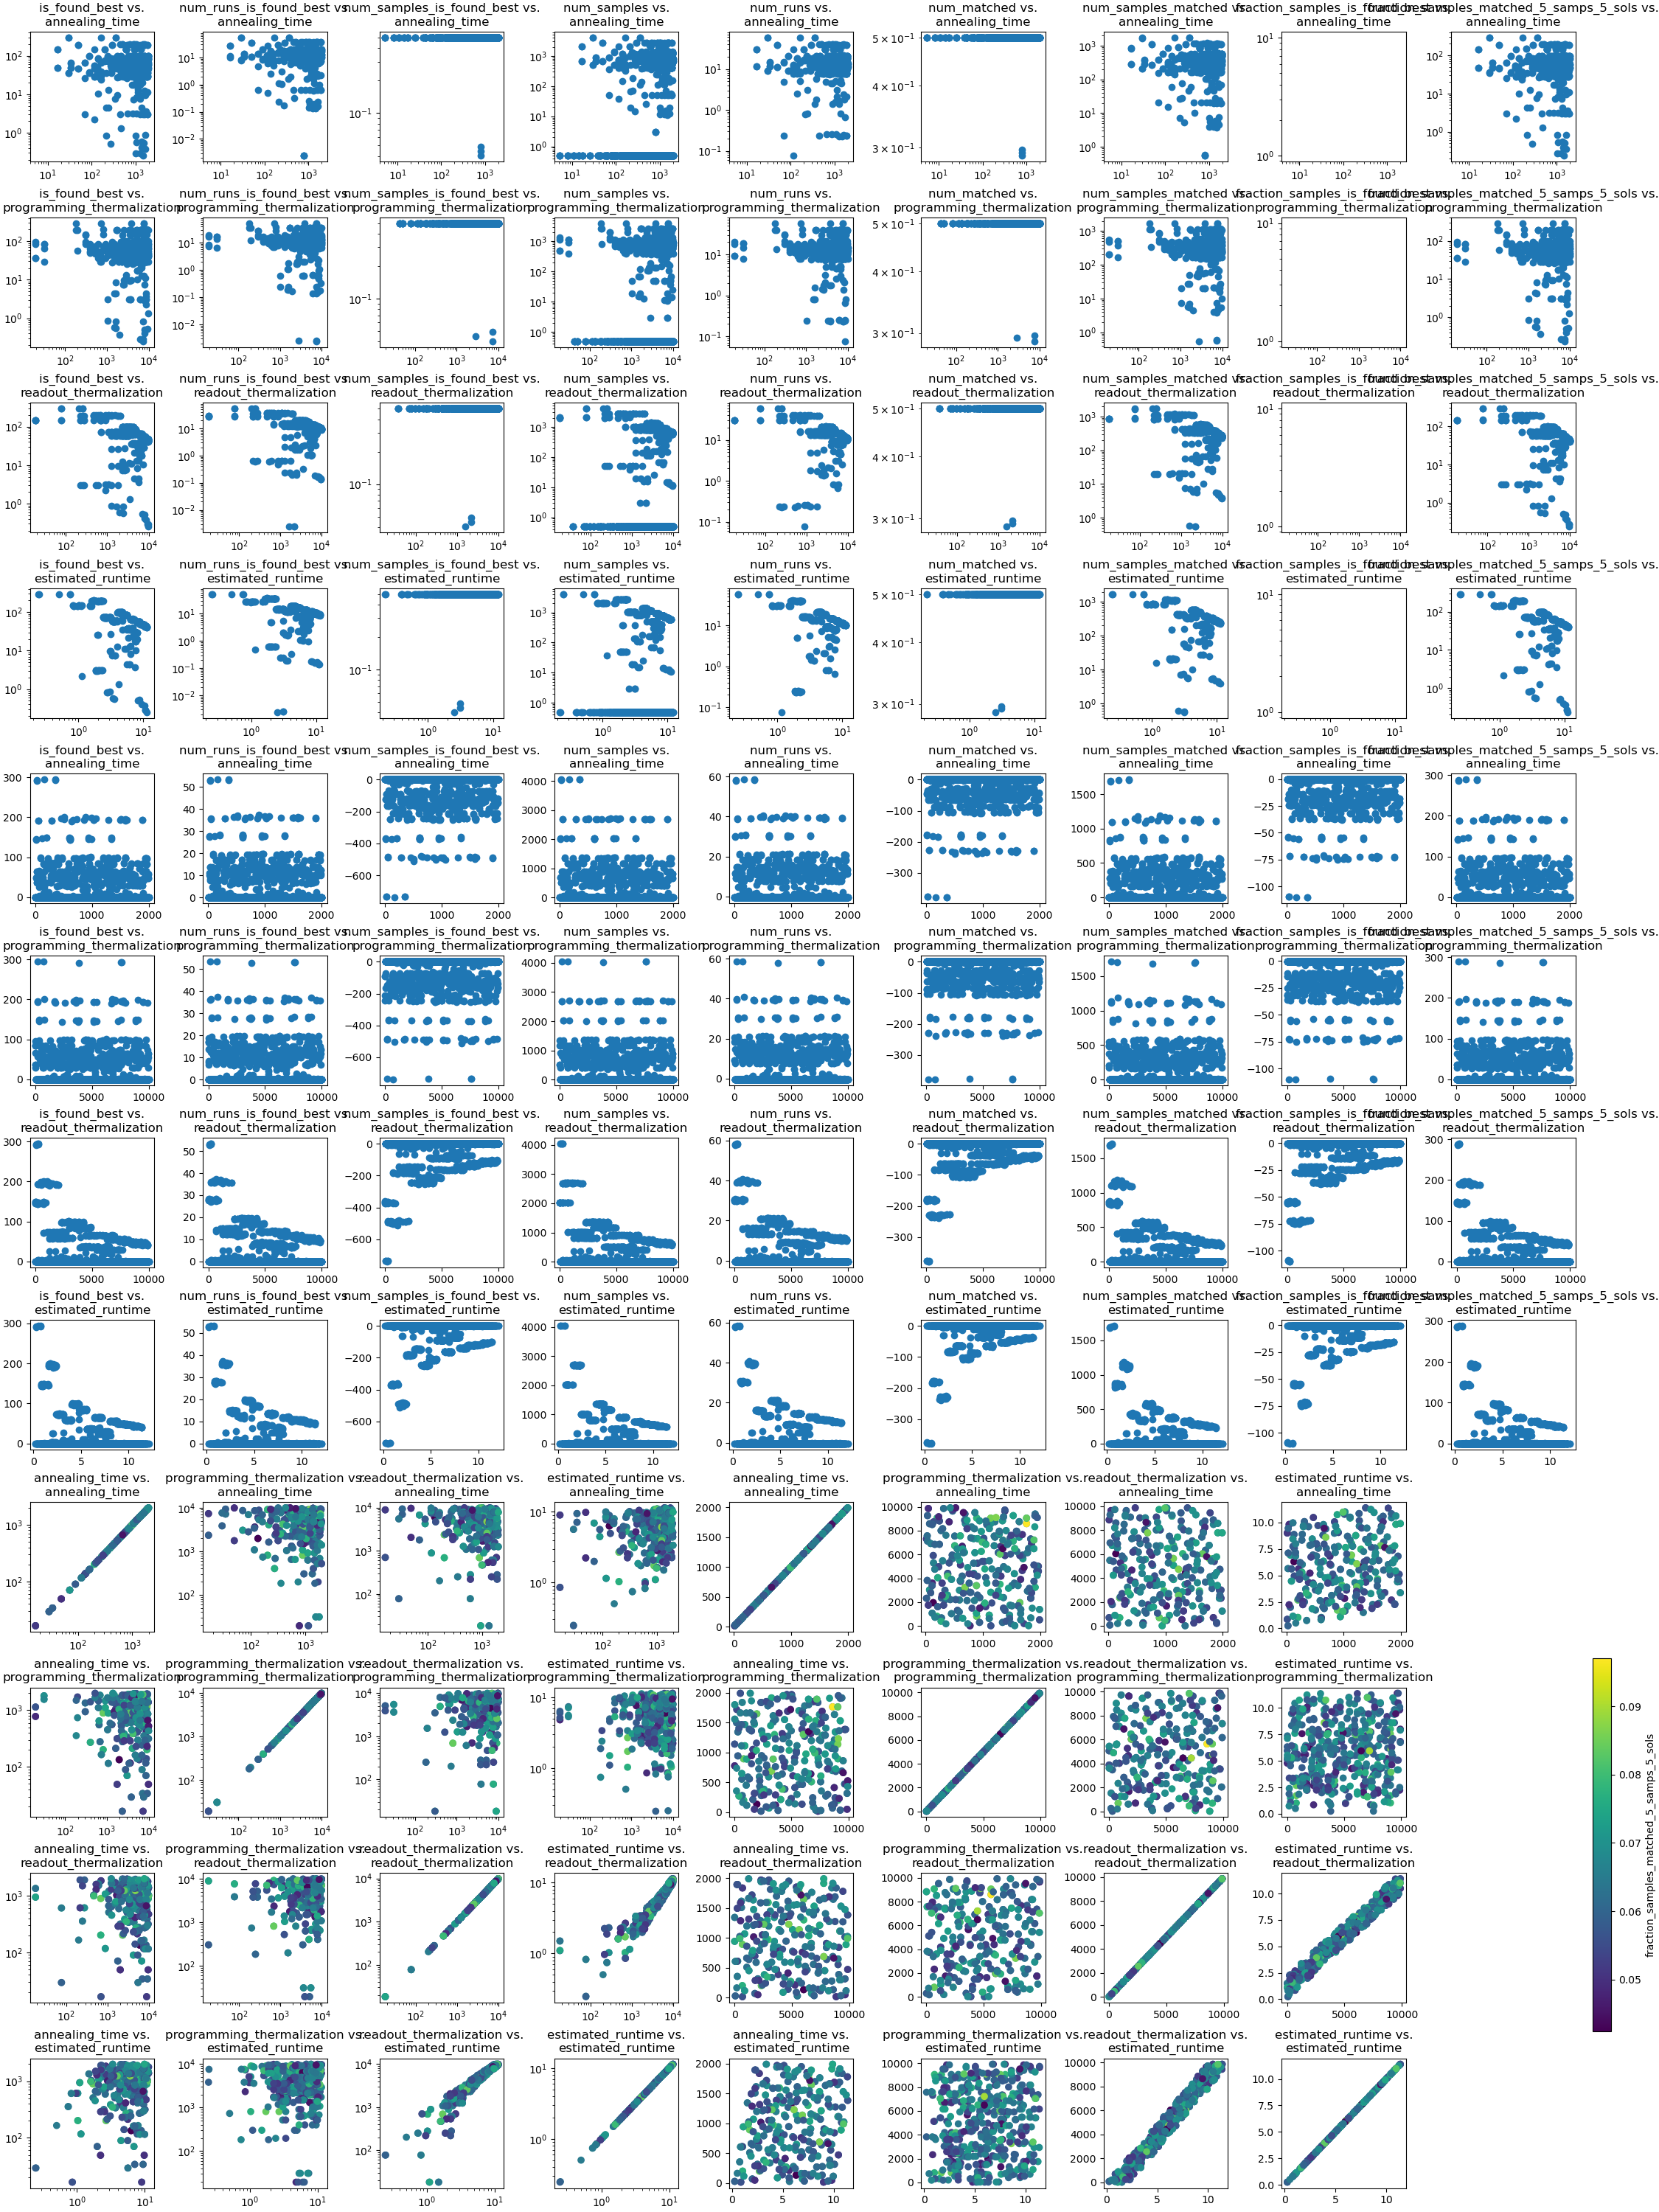

In [127]:
print(results_names)
study_matched_started_ids_sets_cont = study_matched_started_ids['sets'].view((np.float64, len(study_matched_started_ids['sets'].dtype.names))).copy()
print(study_matched_started_ids_sets_cont.shape[1])
print(mean.shape)
cmap = plt.colormaps['viridis']
nrows_uni_log = study_matched_started_ids['sets'].view(np.float64).shape[1]#study_matched_started_ids_sets_cont.shape[1] #study_matched_started_ids['sets'].view(np.float64).shape[1]
ncols_uni_log = mean.shape[1]
nrows_uni_lin = study_matched_started_ids['sets'].view(np.float64).shape[1]#study_matched_started_ids_sets_cont.shape[1] #study_matched_started_ids['sets'].view(np.float64).shape[1]
ncols_uni_lin = mean.shape[1]
nrows_bi_log = study_matched_started_ids['sets'].view(np.float64).shape[1]#study_matched_started_ids_sets_cont.shape[1] #study_matched_started_ids['sets'].view(np.float64).shape[1]
ncols_bi_log = study_matched_started_ids['sets'].view(np.float64).shape[1]#study_matched_started_ids_sets_cont.shape[1] #study_matched_started_ids['sets'].view(np.float64).shape[1]
ncols_bi_lin = study_matched_started_ids['sets'].view(np.float64).shape[1]#study_matched_started_ids_sets_cont.shape[1] #study_matched_started_ids['sets'].view(np.float64).shape[1]
fig2, axs2 = plt.subplots(nrows=nrows_uni_log+nrows_uni_lin+nrows_bi_log, ncols=ncols_uni_log \
                          , figsize=(2.5*ncols_uni_log, 2.5*(nrows_uni_log+nrows_uni_lin+nrows_bi_log))\
                          , layout='compressed')
#fig2, axs2 = plt.subplots(nrows=2, ncols=2)
print(axs2.shape)
for row_id in range(nrows_uni_log):
    for col_id in range(ncols_uni_log):
        axs2[row_id,col_id].scatter(dict_info_read['study']['data']['sets'].view(np.float64)[:,row_id], mean[:,col_id])
        #axs2[row_id,col_id].scatter(study_matched_started_ids_sets_cont[:,row_id], sampler_array[:,col_id])
        axs2[row_id,col_id].set_title(f'{results_names[col_id]} vs.\
\n{dict_info_read['study']['data']['sets'].dtype.names[row_id]}')
        axs2[row_id,col_id].set_xscale('log')
        axs2[row_id,col_id].set_yscale('log')

        axs2[row_id+nrows_uni_log,col_id].scatter(dict_info_read['study']['data']['sets'].view(np.float64)[:,row_id], mean[:,col_id])
        #axs2[row_id+nrows_uni_log,col_id].scatter(study_matched_started_ids_sets_cont[:,row_id], sampler_array[:,col_id])
        axs2[row_id+nrows_uni_log,col_id].set_title(f'{results_names[col_id]} vs.\
\n{dict_info_read['study']['data']['sets'].dtype.names[row_id]}')

colour_label = 'fraction_samples_matched_5_samps_5_sols'
colour_id = np.argwhere(colour_label == np.array(results_names))[0,0]
print(colour_id)
for row_id in range(nrows_bi_log):
    for col_id in range(ncols_bi_log):
        print(row_id, col_id, ncols_bi_log)
        axs2[row_id+nrows_uni_log+nrows_uni_lin,col_id].scatter(study_matched_started_ids['sets'].view(np.float64)[:,row_id], study_matched_started_ids['sets'].view(np.float64)[:,col_id], \
        #axs2[row_id+nrows_uni_log+nrows_uni_lin,col_id].scatter(study_matched_started_ids_sets_cont[:,row_id], study_matched_started_ids_sets_cont[:,col_id], \
                                    c=sampler_array[:,colour_id], cmap=cmap)
        axs2[row_id+nrows_uni_log+nrows_uni_lin,col_id].set_title(f'{dict_info_read['study']['data']['sets'].dtype.names[col_id]} vs.\
\n{dict_info_read['study']['data']['sets'].dtype.names[row_id]}\
')#\n(c={results_names[colour_id]})')
        axs2[row_id+nrows_uni_log+nrows_uni_lin,col_id].set_xscale('log')
        axs2[row_id+nrows_uni_log+nrows_uni_lin,col_id].set_yscale('log')
        # linear axis scale
        axs2[row_id+nrows_uni_log+nrows_uni_lin,col_id+ncols_bi_lin].scatter(study_matched_started_ids['sets'].view(np.float64)[:,row_id], study_matched_started_ids['sets'].view(np.float64)[:,col_id], \
        #axs2[row_id+nrows_uni_log+nrows_uni_lin,col_id+ncols_bi_lin].scatter(study_matched_started_ids_sets_cont[:,row_id], study_matched_started_ids_sets_cont[:,col_id], \
                                    c=sampler_array[:,colour_id], cmap=cmap)
        axs2[row_id+nrows_uni_log+nrows_uni_lin,col_id+ncols_bi_lin].set_title(f'{dict_info_read['study']['data']['sets'].dtype.names[col_id]} vs.\
\n{dict_info_read['study']['data']['sets'].dtype.names[row_id]}\
')#\n(c={results_names[colour_id]})')
    axs2[row_id+nrows_uni_log+nrows_uni_lin,-1].axis('off')





# Hist is problematic with fractions, as we would need to compute fractions of samples/etc w.r.t. the number of occurences in the respective bin, which can not be done by matplotlib directly
#for row_id in range(nrows_uni_hist):
#    for col_id in range(ncols_uni_hist):
#        axs2[row_id+nrows_uni, col_id].hist(x = study_matched_started_ids['sets'].view(np.float64)[:,row_id],
#                                  weights = sampler_array[:,col_id],\
#                                  bins = 20)
#        axs2[row_id+nrows_uni,col_id].set_title(f'{results_names[col_id]} vs.\
#\n{dict_info_read['study']['data']['sets'].dtype.names[row_id]}')


#fig2.tight_layout() # does not work with colorbar, so instead introduced "layout='compressed'" in figure creation
sm = cm.ScalarMappable(norm=plt.Normalize(sampler_array[:,colour_id].min(),sampler_array[:,colour_id].max()),cmap=cmap)
sm.set_array([])
fig2.colorbar(sm, ax=axs2[nrows_uni_log+nrows_uni_lin:,-1].ravel().tolist(), label=colour_label)
fig2.savefig(f'./01_out/fig_{study_name}_{results_names[colour_id]}.svg')
#fig2.savefig(f'./01_out/fig_colorscale_legend.svg')

#axs2[0,0].scatter(dict_info_read['study']['data']['sets'].view(np.float64)[:,0], mean[:,1])
#axs2[0,1].scatter(dict_info_read['study']['data']['sets'].view(np.float64)[:,1], mean[:,1])
#axs2[0,2].scatter(dict_info_read['study']['data']['sets'].view(np.float64)[:,2], mean[:,1])
#axs2[0,3].scatter(dict_info_read['study']['data']['sets'].view(np.float64)[:,3], mean[:,1])
##axs2[0,0].set_xscale('log')
##axs2[0,1].set_xscale('log')
##axs2[0,2].set_xscale('log')
##axs2[0,3].set_xscale('log')
#axs2[0,0].set_ylim((0., 10.))
#axs2[0,1].set_ylim((0., 10.))
#axs2[0,2].set_ylim((0., 10.))
#axs2[0,3].set_ylim((0., 10.))
#axs2[1,0].scatter(dict_info_read['study']['data']['sets'].view(np.float64)[:,0], mean[:,2])
#axs2[1,1].scatter(dict_info_read['study']['data']['sets'].view(np.float64)[:,1], mean[:,2])
#axs2[1,2].scatter(dict_info_read['study']['data']['sets'].view(np.float64)[:,2], mean[:,2])
#axs2[1,3].scatter(dict_info_read['study']['data']['sets'].view(np.float64)[:,3], mean[:,2])
##axs2[1,0].set_xscale('log')
##axs2[1,1].set_xscale('log')
##axs2[1,2].set_xscale('log')
##axs2[1,3].set_xscale('log')
##axs2[1,0].set_ylim((0., 10.))
##axs2[1,1].set_ylim((0., 10.))
##axs2[1,2].set_ylim((0., 10.))
#axs2[1,3].set_ylim((0., 10.))
plt.show()

In [128]:
axs2.ravel().tolist()
plt.close()

No such comm: ae5b99baadc749ed82a6961a9ed8f09b


In [129]:
import plotly.express as px

In [130]:
dict_parallel_plot_inputs = {name: study_matched_started_ids['sets'][name].flatten()for name in study_matched_started_ids['sets'].dtype.names}
#dict_parallel_plot_inputs = {name: study_matched_started_ids['sets'][name] for name in study_matched_started_ids['sets'].dtype.names}
dict_parallel_plot_outputs = {results_names[i]: sampler_array[:,i] for i in range(len(results_names))}
dict_parallel_plot = dict_parallel_plot_inputs | dict_parallel_plot_outputs # merges two dicts
print(dict_parallel_plot)

{'annealing_time': array([1699.68586519,  465.3469867 , 1635.62975857, 1699.68586519,
       1211.91890706, 1699.68586519, 1635.62975857, 1699.68586519,
       1635.62975857,  465.3469867 , 1635.62975857,  465.3469867 ,
       1211.91890706, 1211.91890706,  465.3469867 , 1211.91890706,
        776.71912319,  841.72206616, 1140.02476593,  387.0936069 ,
        776.71912319,  841.72206616,  776.71912319,  841.72206616,
        776.71912319,  841.72206616,  387.0936069 , 1140.02476593,
        387.0936069 , 1140.02476593,  387.0936069 , 1140.02476593,
        133.98029386,  201.72707636, 1647.05970081,  893.51619757,
        133.98029386,  201.72707636,  133.98029386,  201.72707636,
        133.98029386, 1647.05970081,  201.72707636, 1647.05970081,
        893.51619757,  893.51619757, 1647.05970081,  893.51619757,
       1343.78100791, 1275.02824626,  942.93223082, 1689.13588656,
       1343.78100791, 1275.02824626, 1343.78100791, 1275.02824626,
       1275.02824626, 1343.78100791, 1689.1

In [131]:
fig_pp1 = px.parallel_coordinates(
    dict_parallel_plot,
    color=results_names[colour_id],
    color_continuous_scale=px.colors.sequential.Viridis)
#fig_pp1.update_layout(coloraxis_showscale=False)
fig_pp1.write_html(f'./01_out/fig_{study_name}_{results_names[colour_id]}_parallel_plot.html')
fig_pp1.show()